In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cityblock
import scipy.stats as stats
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA


warnings.filterwarnings('ignore')

In [2]:
PM10=pd.read_csv("PM10_E43.csv")
PM10.rename(columns = {'mg/m^3_43':'mg/m^3'}, inplace = True)
PM10

,DATETIME,mg/m^3
0,2019-06-01 01:00:00,29.0
1,2019-06-01 02:00:00,25.0
2,2019-06-01 03:00:00,12.0
3,2019-06-01 04:00:00,11.0
4,2019-06-01 05:00:00,10.0
...,...,...
25891,2022-05-31 20:00:00,34.0
25892,2022-05-31 21:00:00,39.0
25893,2022-05-31 22:00:00,32.0
25894,2022-05-31 23:00:00,30.0


In [3]:
PM10.describe()

,mg/m^3
count,24652.000000
mean,26.639705
std,17.667350
min,1.000000
25%,16.000000
50%,24.000000
75%,33.000000
max,564.000000


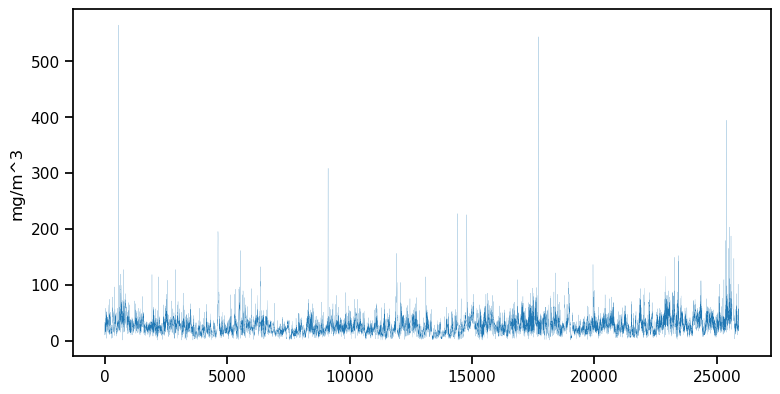

In [4]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=PM10["mg/m^3"],linewidth=.1)
plt.show()

## Missing values analysis

In [5]:
# % of missing values
PM10.count()/len(PM10)

DATETIME    1.000000
mg/m^3      0.951962
dtype: float64

In [6]:
PM10[ "mg/m^3_acum_NAN"]= 0

for j in range(1,len(PM10)):

    if PM10["mg/m^3"].isna()[j] == True :
        PM10[ "mg/m^3_acum_NAN"][j] = PM10[ "mg/m^3_acum_NAN"][j-1]+1   
        
        
    else:
        PM10[ "mg/m^3_acum_NAN"][j] = 0

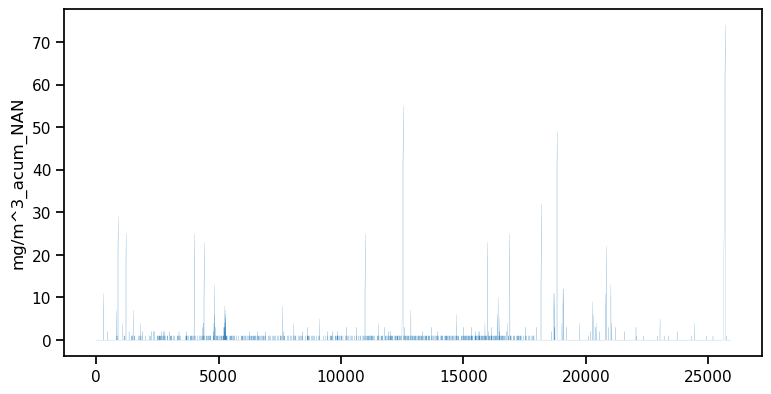

In [7]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=PM10["mg/m^3_acum_NAN"],linewidth=.1)
plt.show()

In [8]:
PM10[ "mg/m^3_peaks_acum_NAN"]= PM10[ "mg/m^3_acum_NAN"]


for j in range(1,len(PM10)):

    if (PM10["mg/m^3_acum_NAN"][j] == 0) or (PM10["mg/m^3_acum_NAN"][j+1] > 0) :
          
        PM10[ "mg/m^3_peaks_acum_NAN"][j] = 0

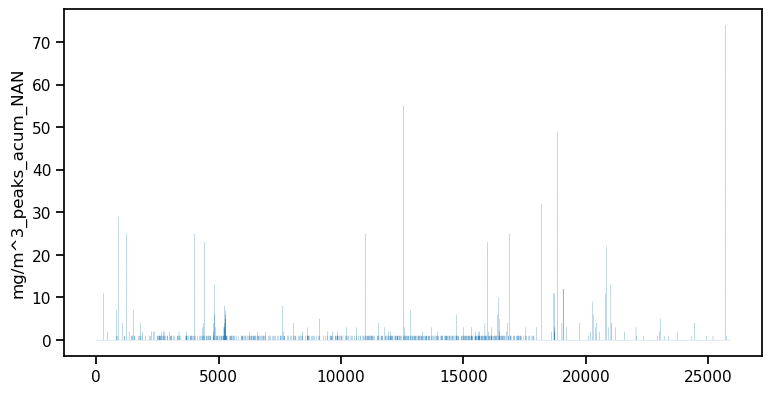

In [9]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=PM10["mg/m^3_peaks_acum_NAN"],linewidth=.1)
plt.show()

In [10]:
PM10["mg/m^3_peaks_acum_NAN"].value_counts().sort_index()

0     25351
1       435
2        38
3        21
4        14
5         4
6         5
7         4
8         2
9         1
10        1
11        4
12        2
13        2
22        1
23        2
25        4
29        1
32        1
49        1
55        1
74        1
Name: mg/m^3_peaks_acum_NAN, dtype: int64

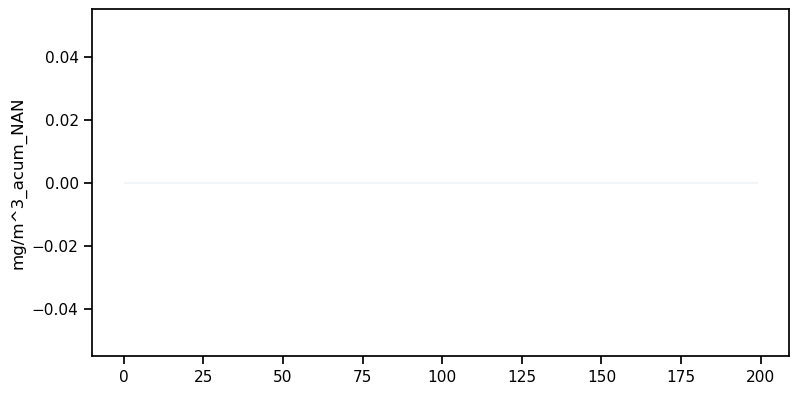

In [11]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
sns.lineplot(data=PM10[:200]["mg/m^3_acum_NAN"],linewidth=.1)
plt.show()

In [12]:
PM10["mg/m^3_im"] = PM10["mg/m^3"].fillna(PM10["mg/m^3"].mean())
PM10

,DATETIME,mg/m^3,mg/m^3_acum_NAN,mg/m^3_peaks_acum_NAN,mg/m^3_im
0,2019-06-01 01:00:00,29.0,0,0,29.0
1,2019-06-01 02:00:00,25.0,0,0,25.0
2,2019-06-01 03:00:00,12.0,0,0,12.0
3,2019-06-01 04:00:00,11.0,0,0,11.0
4,2019-06-01 05:00:00,10.0,0,0,10.0
...,...,...,...,...,...
25891,2022-05-31 20:00:00,34.0,0,0,34.0
25892,2022-05-31 21:00:00,39.0,0,0,39.0
25893,2022-05-31 22:00:00,32.0,0,0,32.0
25894,2022-05-31 23:00:00,30.0,0,0,30.0


## 24h mean analysis

In [13]:
PM10["mg/m^3_im_24h"] = np.nan

for j in range(23, len(PM10)):

    PM10[ "mg/m^3_im_24h"][j] = PM10["mg/m^3_im"][j-23:j+1].mean()
    
PM10

,DATETIME,mg/m^3,mg/m^3_acum_NAN,mg/m^3_peaks_acum_NAN,mg/m^3_im,mg/m^3_im_24h
0,2019-06-01 01:00:00,29.0,0,0,29.0,NaN
1,2019-06-01 02:00:00,25.0,0,0,25.0,NaN
2,2019-06-01 03:00:00,12.0,0,0,12.0,NaN
3,2019-06-01 04:00:00,11.0,0,0,11.0,NaN
4,2019-06-01 05:00:00,10.0,0,0,10.0,NaN
...,...,...,...,...,...,...
25891,2022-05-31 20:00:00,34.0,0,0,34.0,31.583333
25892,2022-05-31 21:00:00,39.0,0,0,39.0,32.125000
25893,2022-05-31 22:00:00,32.0,0,0,32.0,32.458333
25894,2022-05-31 23:00:00,30.0,0,0,30.0,32.666667


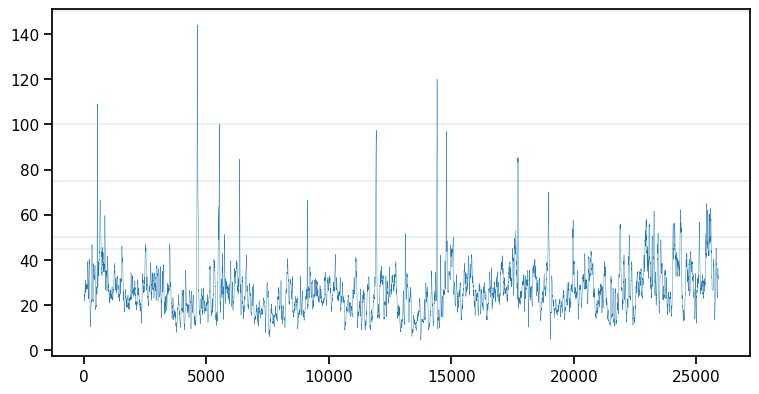

In [14]:
plt.figure(figsize=(9,4.5))
#sns.set_context("notebook")
#sns.axes_style("whitegrid")
#graph = sns.lineplot(data=NO2["mg/m^3_43_24h"],linewidth=.1)

graph = plt.plot(PM10["mg/m^3_im_24h"],linewidth=.3)

plt.axhline(y=150,linewidth=.15)
plt.axhline(y=100,linewidth=.15)
plt.axhline(y=75,linewidth=.15)
plt.axhline(y=50,linewidth=.15)
plt.axhline(y=45,linewidth=.15)

plt.show()

In [17]:
PM10["AQG"] = np.nan

for j in range(len(PM10)):
    if PM10[ "mg/m^3_im_24h"][j]<= 45:
        PM10["AQG"][j] = "+"
    elif 45<PM10[ "mg/m^3_im_24h"][j]<= 50:
        PM10["AQG"][j] = "I1"
    elif 50<PM10[ "mg/m^3_im_24h"][j]<= 75:
        PM10["AQG"][j] = "I3"
    elif 75<PM10[ "mg/m^3_im_24h"][j]<= 100:
        PM10["AQG"][j] = "I4"
    elif 100<PM10[ "mg/m^3_im_24h"][j]<= 150:
        PM10["AQG"][j] = "I5"   
    elif PM10[ "mg/m^3_im_24h"][j]> 150:
        PM10["AQG"][j] = "-"    
    
PM10["AQG"].value_counts()

+     24612
I3      629
I1      447
I4      125
I5       60
Name: AQG, dtype: int64

## 1y mean analysis

In [15]:
PM10["mg/m^3_im_1y"] = np.nan

for j in range(8759, len(PM10)):

    PM10[ "mg/m^3_im_1y"][j] = PM10["mg/m^3_im"][j-8759:j+1].mean()
    
PM10

,DATETIME,mg/m^3,mg/m^3_acum_NAN,mg/m^3_peaks_acum_NAN,mg/m^3_im,mg/m^3_im_24h,mg/m^3_im_1y
0,2019-06-01 01:00:00,29.0,0,0,29.0,NaN,NaN
1,2019-06-01 02:00:00,25.0,0,0,25.0,NaN,NaN
2,2019-06-01 03:00:00,12.0,0,0,12.0,NaN,NaN
3,2019-06-01 04:00:00,11.0,0,0,11.0,NaN,NaN
4,2019-06-01 05:00:00,10.0,0,0,10.0,NaN,NaN
...,...,...,...,...,...,...,...
25891,2022-05-31 20:00:00,34.0,0,0,34.0,31.583333,29.511810
25892,2022-05-31 21:00:00,39.0,0,0,39.0,32.125000,29.515120
25893,2022-05-31 22:00:00,32.0,0,0,32.0,32.458333,29.515463
25894,2022-05-31 23:00:00,30.0,0,0,30.0,32.666667,29.516605


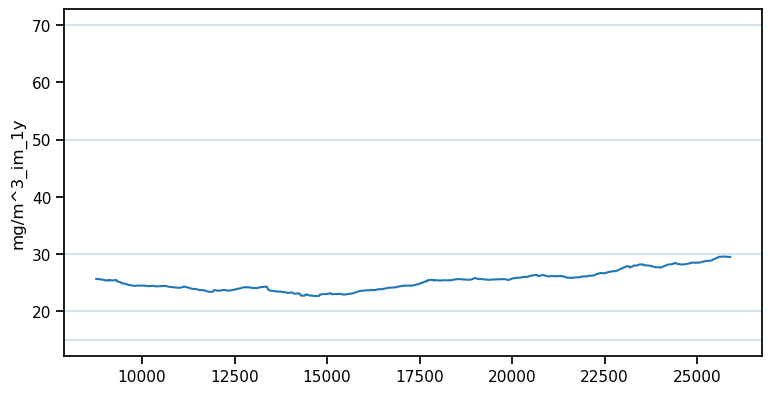

In [16]:
plt.figure(figsize=(9,4.5))
sns.set_context("notebook")
sns.axes_style("whitegrid")
graph = sns.lineplot(data=PM10["mg/m^3_im_1y"])

graph.axhline(70,linewidth=.3)
graph.axhline(50,linewidth=.3)
graph.axhline(30,linewidth=.3)
graph.axhline(20,linewidth=.3)
graph.axhline(15,linewidth=.3)

plt.show()

## ARIMA forecasting

In [17]:
size = int(len(PM10["mg/m^3_im"])*.8)

train, test = PM10["mg/m^3_im"].iloc[:size], PM10["mg/m^3_im"].iloc[size:]

In [18]:
step_fit = auto_arima(PM10["mg/m^3_im"],trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=190820.637, Time=31.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=193390.057, Time=0.64 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=193169.974, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=193101.047, Time=3.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=193388.057, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=190827.560, Time=12.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=190827.939, Time=15.84 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=190820.015, Time=41.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=190822.920, Time=21.68 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=190826.919, Time=25.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=190815.469, Time=32.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=190820.201, Time=25.51 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=190813.045, Time=46.83 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=190816.937, Time=56.89

In [19]:
step_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                25896
Model:               SARIMAX(4, 1, 4)   Log Likelihood              -95378.938
Date:                Tue, 05 Jul 2022   AIC                         190775.877
Time:                        16:36:23   BIC                         190849.333
Sample:                             0   HQIC                        190799.612
                              - 25896                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2013      0.080      2.515      0.012       0.044       0.358
ar.L2         -0.5078      0.063     -8.107      0.000      -0.631      -0.385
ar.L3          0.1868      0.078      2.383      0.017       0.033       0.340
ar.L4          0.4636      0.064      7.273      0.000       0.339       0.589
ma.L1         -0.3877      0.080     -4.853      0.000      -0.544      -0.231
ma.L2          0.3706      0.078      4.767      0.000       0.218       0.523
ma.L3         -0.3542      0.077     -4.597      0.000      -0.505      -0.203
ma.L4         -0.5967      0.078     -7.654      0.000      -0.750      -0.444
sigma2        92.4835      0.092   1006.997      0.000      92.303      92.663
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          42252386.97
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             5.08
Prob(H) (two-sided):                  0.00   Kurtosis:                       200.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
model = ARIMA(PM10["mg/m^3_im"],order=(2,1,2))
model = model.fit(method='mle')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.mg/m^3_im   No. Observations:                25895
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -95404.318
Method:                           mle   S.D. of innovations              9.634
Date:                Tue, 05 Jul 2022   AIC                         190820.637
Time:                        16:37:05   BIC                         190869.608
Sample:                             1   HQIC                        190836.460
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0002      0.005      0.050      0.960      -0.009       0.009
ar.L1.D.mg/m^3_im     0.2480      0.112      2.209      0.027       0.028       0.468
ar.L2.D.mg/m^3_im     0.4086      0.089      4.579      0.000       0.234       0.584
ma.L1.D.mg/m^3_im    -0.4316      0.111     -3.895      0.000      -0.649      -0.214
ma.L2.D.mg/m^3_im    -0.5416      0.109     -4.956      0.000      -0.756      -0.327
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2900           +0.0000j            1.2900            0.0000
AR.2           -1.8970           +0.0000j            1.8970            0.5000
MA.1            1.0175           +0.0000j            1.0175            0.0000
MA.2           -1.8144           +0.0000j            1.8144            0.5000
-----------------------------------------------------------------------------
"""

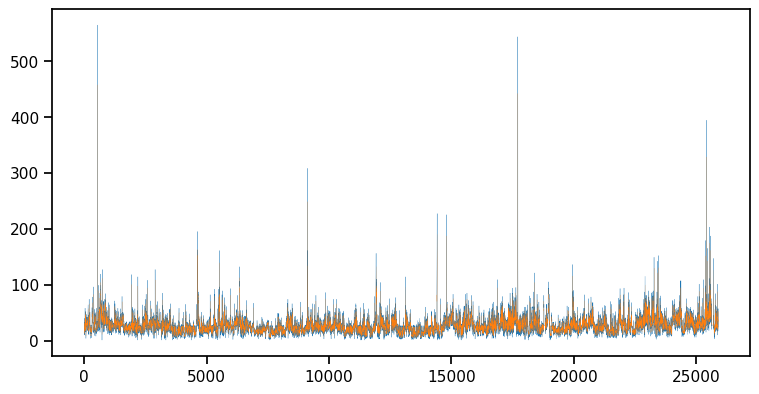

In [21]:
pred=model.predict(typ='levels')
plt.figure(figsize=(9,4.5))


plt.plot(PM10["mg/m^3_im"], linewidth =.2)
plt.plot(pred, linewidth=.1)
plt.show()

In [22]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape(pred,PM10["mg/m^3_im"][2:])

20.096757374975276